# Final Project for Research Computing in Earth Science
## *Investigating Ocean Acidification in the Arctic* 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pooch
import ipywidgets as widgets
import matplotlib
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Data Import and Creation of Datasets

In [2]:
xr.set_options(display_expand_attrs=False)

## CESM Historical Data

### Import data and compile

In [3]:
# structure : {base_url}{variables}{scenarios}
historical_base_url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/CESM2_{}_historical.nc#mode=bytes'
variables = ['Temperature','Salinity','pHT','pCO2']

historical_url_list = []
for variable in variables:
    historical_url_list.append(historical_base_url.format(variable)) 
    
data = []
for url in historical_url_list:
    data.append(xr.open_dataset(url))
        
cesm_historical = xr.merge(data)   
cesm_historical

<xarray.Dataset>
Dimensions:      (time: 18, lat: 180, lon: 360)
Coordinates:
  * time         (time) float64 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
Dimensions without coordinates: lat, lon
Data variables:
    temperature  (time, lat, lon) float64 ...
    longitude    (lat, lon) float64 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
    latitude     (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    salinity     (time, lat, lon) float64 ...
    pHT          (time, lat, lon) float64 ...
    pCO2         (time, lat, lon) float64 ...
Attributes: (8)

### To ease later analysis, will: 
- Use pandas to recognize time as dates 
    - Note that this puts years in year-month-day format, even though each variable is representing a whole decade
    - Will keep this mind for conclusions but make the change anyway, because enables easier selection during analysis
- Fix latitude and longitude
    - Lat/lon dimensions are only integer lists, replace with latitude/longitude variables
    - Set latitude and longitude as additional coordinates
    - Also note that longitude is given in 20.5 to 379.5 degrees, wrap angle to -180 to 180

In [4]:
longitude = cesm_historical['longitude'][1,:].rename({'lon': 'longitude'})
latitude = cesm_historical['latitude'][:,1].rename({'lat': 'latitude'})
cesm_historical = cesm_historical.drop(['longitude', 'latitude']).rename({'lat': 'latitude', 'lon': 'longitude'})
cesm_historical = cesm_historical.assign_coords(longitude=longitude).assign_coords(latitude=latitude)
cesm_historical = cesm_historical.assign_coords(longitude=(((cesm_historical.longitude+180)%360)-180)) # wraps from 20 to 380 to -180 to 179
cesm_historical = cesm_historical.sortby(cesm_historical.longitude) #need longitude in increasing order to preserve plotting functionality
cesm_historical['time'] = pd.to_datetime(cesm_historical.time, format='%Y')
cesm_historical

<xarray.Dataset>
Dimensions:      (time: 18, latitude: 180, longitude: 360)
Coordinates:
  * time         (time) datetime64[ns] 1750-01-01 1850-01-01 ... 2010-01-01
  * longitude    (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    temperature  (time, latitude, longitude) float64 ...
    salinity     (time, latitude, longitude) float64 ...
    pHT          (time, latitude, longitude) float64 ...
    pCO2         (time, latitude, longitude) float64 ...
Attributes: (8)

## CESM Emission Scenarios

[Index of /data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2]('https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/')

### Import data and compile

In [5]:
# structure : {base_url}{variables}{scenarios}
cesm = {}
cesm_base_url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/CESM2_{}_{}.nc#mode=bytes'
scenarios = ['ssp126','ssp245','ssp370','ssp585'] 
variables = ['Temperature','Salinity','pHT','pCO2']

for scenario in scenarios:
    cesm_url_list = []
    for variable in variables:
        cesm_url_list.append(cesm_base_url.format(variable,scenario)) 
    
    data = []
    for url in cesm_url_list:
        data.append(xr.open_dataset(url))
        
    cesm[scenario] = xr.merge(data)   

### At this stage, have each scenario stored as Xarray dataset, with all emission scenarios combined into "cesm" dictionary

In [6]:
# type(cesm)

In [7]:
cesm

{'ssp126': <xarray.Dataset>
 Dimensions:      (time: 9, lat: 180, lon: 360)
 Coordinates:
   * time         (time) int64 2020 2030 2040 2050 2060 2070 2080 2090 2100
 Dimensions without coordinates: lat, lon
 Data variables:
     temperature  (time, lat, lon) float64 ...
     longitude    (lat, lon) float64 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
     latitude     (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
     salinity     (time, lat, lon) float64 ...
     pHT          (time, lat, lon) float64 ...
     pCO2         (time, lat, lon) float64 ...
 Attributes: (8),
 'ssp245': <xarray.Dataset>
 Dimensions:      (time: 9, lat: 180, lon: 360)
 Coordinates:
   * time         (time) int64 2020 2030 2040 2050 2060 2070 2080 2090 2100
 Dimensions without coordinates: lat, lon
 Data variables:
     temperature  (time, lat, lon) float64 ...
     longitude    (lat, lon) float64 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
     latitude     (lat, lon) float64 -89.5 -89.5 -89.5 -89.

In [8]:
# type(cesm['ssp126'])

### To ease later analysis, will conduct same processing performed on historical dataset 
- Use pandas to recognize time as dates 
    - Note that this puts years in year-month-day format, even though each variable is representing a whole decade
    - Will keep this mind for conclusions but make the change anyway, because enables easier selection during analysis
- Fix latitude and longitude
    - Lat/lon dimensions are only integer lists, replace with latitude/longitude variables
    - Set latitude and longitude as additional coordinates
    - Also note that longitude is given in 20.5 to 379.5 degrees, wrap angle to -180 to 180

In [9]:
for scenario in scenarios:
    longitude = cesm[scenario]['longitude'][1,:].rename({'lon': 'longitude'})
    latitude = cesm[scenario]['latitude'][:,1].rename({'lat': 'latitude'})
    cesm[scenario] = cesm[scenario].drop(['longitude', 'latitude']).rename({'lat': 'latitude', 'lon': 'longitude'})
    cesm[scenario] = cesm[scenario].assign_coords(longitude=longitude).assign_coords(latitude=latitude)
    cesm[scenario] = cesm[scenario].assign_coords(longitude=(((cesm[scenario].longitude+180)%360)-180)) # wraps from 20 to 380 to -180 to 179
    cesm[scenario] = cesm[scenario].sortby(cesm[scenario].longitude)
    cesm[scenario]['time'] = pd.to_datetime(cesm[scenario].time, format='%Y')

In [10]:
cesm['ssp126']

<xarray.Dataset>
Dimensions:      (time: 9, latitude: 180, longitude: 360)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2030-01-01 ... 2100-01-01
  * longitude    (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    temperature  (time, latitude, longitude) float64 ...
    salinity     (time, latitude, longitude) float64 ...
    pHT          (time, latitude, longitude) float64 ...
    pCO2         (time, latitude, longitude) float64 ...
Attributes: (8)

In [11]:
# cesm['ssp585'].pHT.min()

## Sea Ice Extent

[Sea Ice Concentration, NOAA/NSIDC Climate Data Record V3, Arctic, 25km, Science Quality, 1978-2019, Monthly DEPRECATED]('https://polarwatch.noaa.gov/erddap/files/nsidcCDRiceSQnhmday/')

Will determine sea ice extent by sea ice concentration, defined where sea ice concentration is less than 15% in September of each year (as done in Krasting et al. 2022)

In [12]:
from erddapy import ERDDAP
import json
e = ERDDAP(
    server='https://polarwatch.noaa.gov/erddap',
    protocol='griddap')

### First get latitude and longitude grid for the Arctic (Northern Hemisphere)

In [13]:
e.dataset_id = 'nsidcCDRice_nh_grid' # https://polarwatch.noaa.gov/erddap/griddap/nsidcCDRice_nh_grid.html
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')
ds_latlon = e.to_xarray()
ds_latlon.load()

variables in this dataset:

['longitude', 'latitude']

constraints for this dataset:

{
 "ygrid>=": 5837500.0,
 "ygrid<=": -5337500.0,
 "ygrid_step": 1,
 "xgrid>=": -3837500.0,
 "xgrid<=": 3737500.0,
 "xgrid_step": 1
}


<xarray.Dataset>
Dimensions:    (ygrid: 448, xgrid: 304)
Coordinates:
  * ygrid      (ygrid) float32 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid      (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    longitude  (ygrid, xgrid) float64 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
    latitude   (ygrid, xgrid) float64 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
Attributes: (62)

### Then get sea ice concentration on a monthly basis from 1978 to 2022

In [14]:
e.dataset_id = 'nsidcG02202v4nhmday' # https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.html
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')
e.variables = ['cdr_seaice_conc_monthly'] #  consider if need any other variables from list printed by line above
e.constraints = None
ds = e.to_xarray()
ds

variables in this dataset:

['cdr_seaice_conc_monthly', 'melt_onset_day_cdr_seaice_conc_monthly', 'nsidc_bt_seaice_conc_monthly', 'nsidc_nt_seaice_conc_monthly', 'qa_of_cdr_seaice_conc_monthly', 'stdev_of_cdr_seaice_conc_monthly']

constraints for this dataset:

{
 "time>=": "2022-05-01T00:00:00Z",
 "time<=": "2022-05-01T00:00:00Z",
 "time_step": 1,
 "ygrid>=": 5837500.0,
 "ygrid<=": -5337500.0,
 "ygrid_step": 1,
 "xgrid>=": -3837500.0,
 "xgrid<=": 3737500.0,
 "xgrid_step": 1
}


<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (65)

In [15]:
ds_ice = xr.merge([ds, ds_latlon])
ds_ice

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
    longitude                (ygrid, xgrid) float64 168.3 168.1 ... -9.999
    latitude                 (ygrid, xgrid) float64 31.1 31.2 ... 34.58 34.47
Attributes: (65)

### To ease later analysis:
- Set coordinates as latitude and longitude
- (Note that time is already correctly identified as dates)

In [16]:
ds_ice = ds_ice.set_coords(['latitude', 'longitude'])
ds_ice

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    longitude                (ygrid, xgrid) float64 168.3 168.1 ... -9.999
    latitude                 (ygrid, xgrid) float64 31.1 31.2 ... 34.58 34.47
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (65)

In [17]:
#ds_ice.latitude.min()

In [18]:
#ds_ice.latitude.max()

# Characterization Figures

### Create Plots to Examine CESM Data

In [19]:
date_options = cesm['ssp585'].time
date_labels = ['2020','2030','2040','2050','2060','2070','2080','2090','2100']

def merge(labels, values):
      
    merged_list = [(labels[i], values[i]) for i in range(0, len(labels))]
    return merged_list
      
merged_dates = merge(date_labels, date_options)

In [44]:
# to check that pH range is reasonable
# cesm_historical.sel(time='1750').pHT.max()

In [45]:
# to check that pH range is reasonable
# cesm['ssp585'].sel(time='2100').pHT.min() 

In [46]:
def create_comparison(Select_date):
    scenarios_min = cesm['ssp585'].pHT.min()
    scenarios_max = cesm_historical.pHT.max()

    fig, axes = plt.subplots(figsize=(12,15),nrows=3)
    ax0, ax1, ax2 = axes

    cesm_historical.sel(time='1750-01-01').pHT.plot(ax=ax0,vmin=scenarios_min,vmax=scenarios_max,cmap='Spectral_r')
    ax0.set_title('(For Reference) Pre-Industrial Global pH')
   # ax0.coastlines()
    
    cesm['ssp126'].sel(time=Select_date,method='nearest').pHT.plot(ax=ax1,vmin=scenarios_min,vmax=scenarios_max,cmap='Spectral_r')
    ax1.set_title('Global pH under Low Emission Scenario')
  #  ax1.coastlines()
    
    cesm['ssp585'].sel(time=Select_date,method='nearest').pHT.plot(ax=ax2,vmin=scenarios_min,vmax=scenarios_max,cmap='Spectral_r')
    ax2.set_title('Global pH under High Emission Scenario')
  #  ax2.coastlines()

In [47]:
widgets.interact(create_comparison,Select_date=merged_dates)

interactive(children=(Dropdown(description='Select_date', options=(('2020', <xarray.DataArray 'time' ()>
array…

<function __main__.create_comparison(Select_date)>

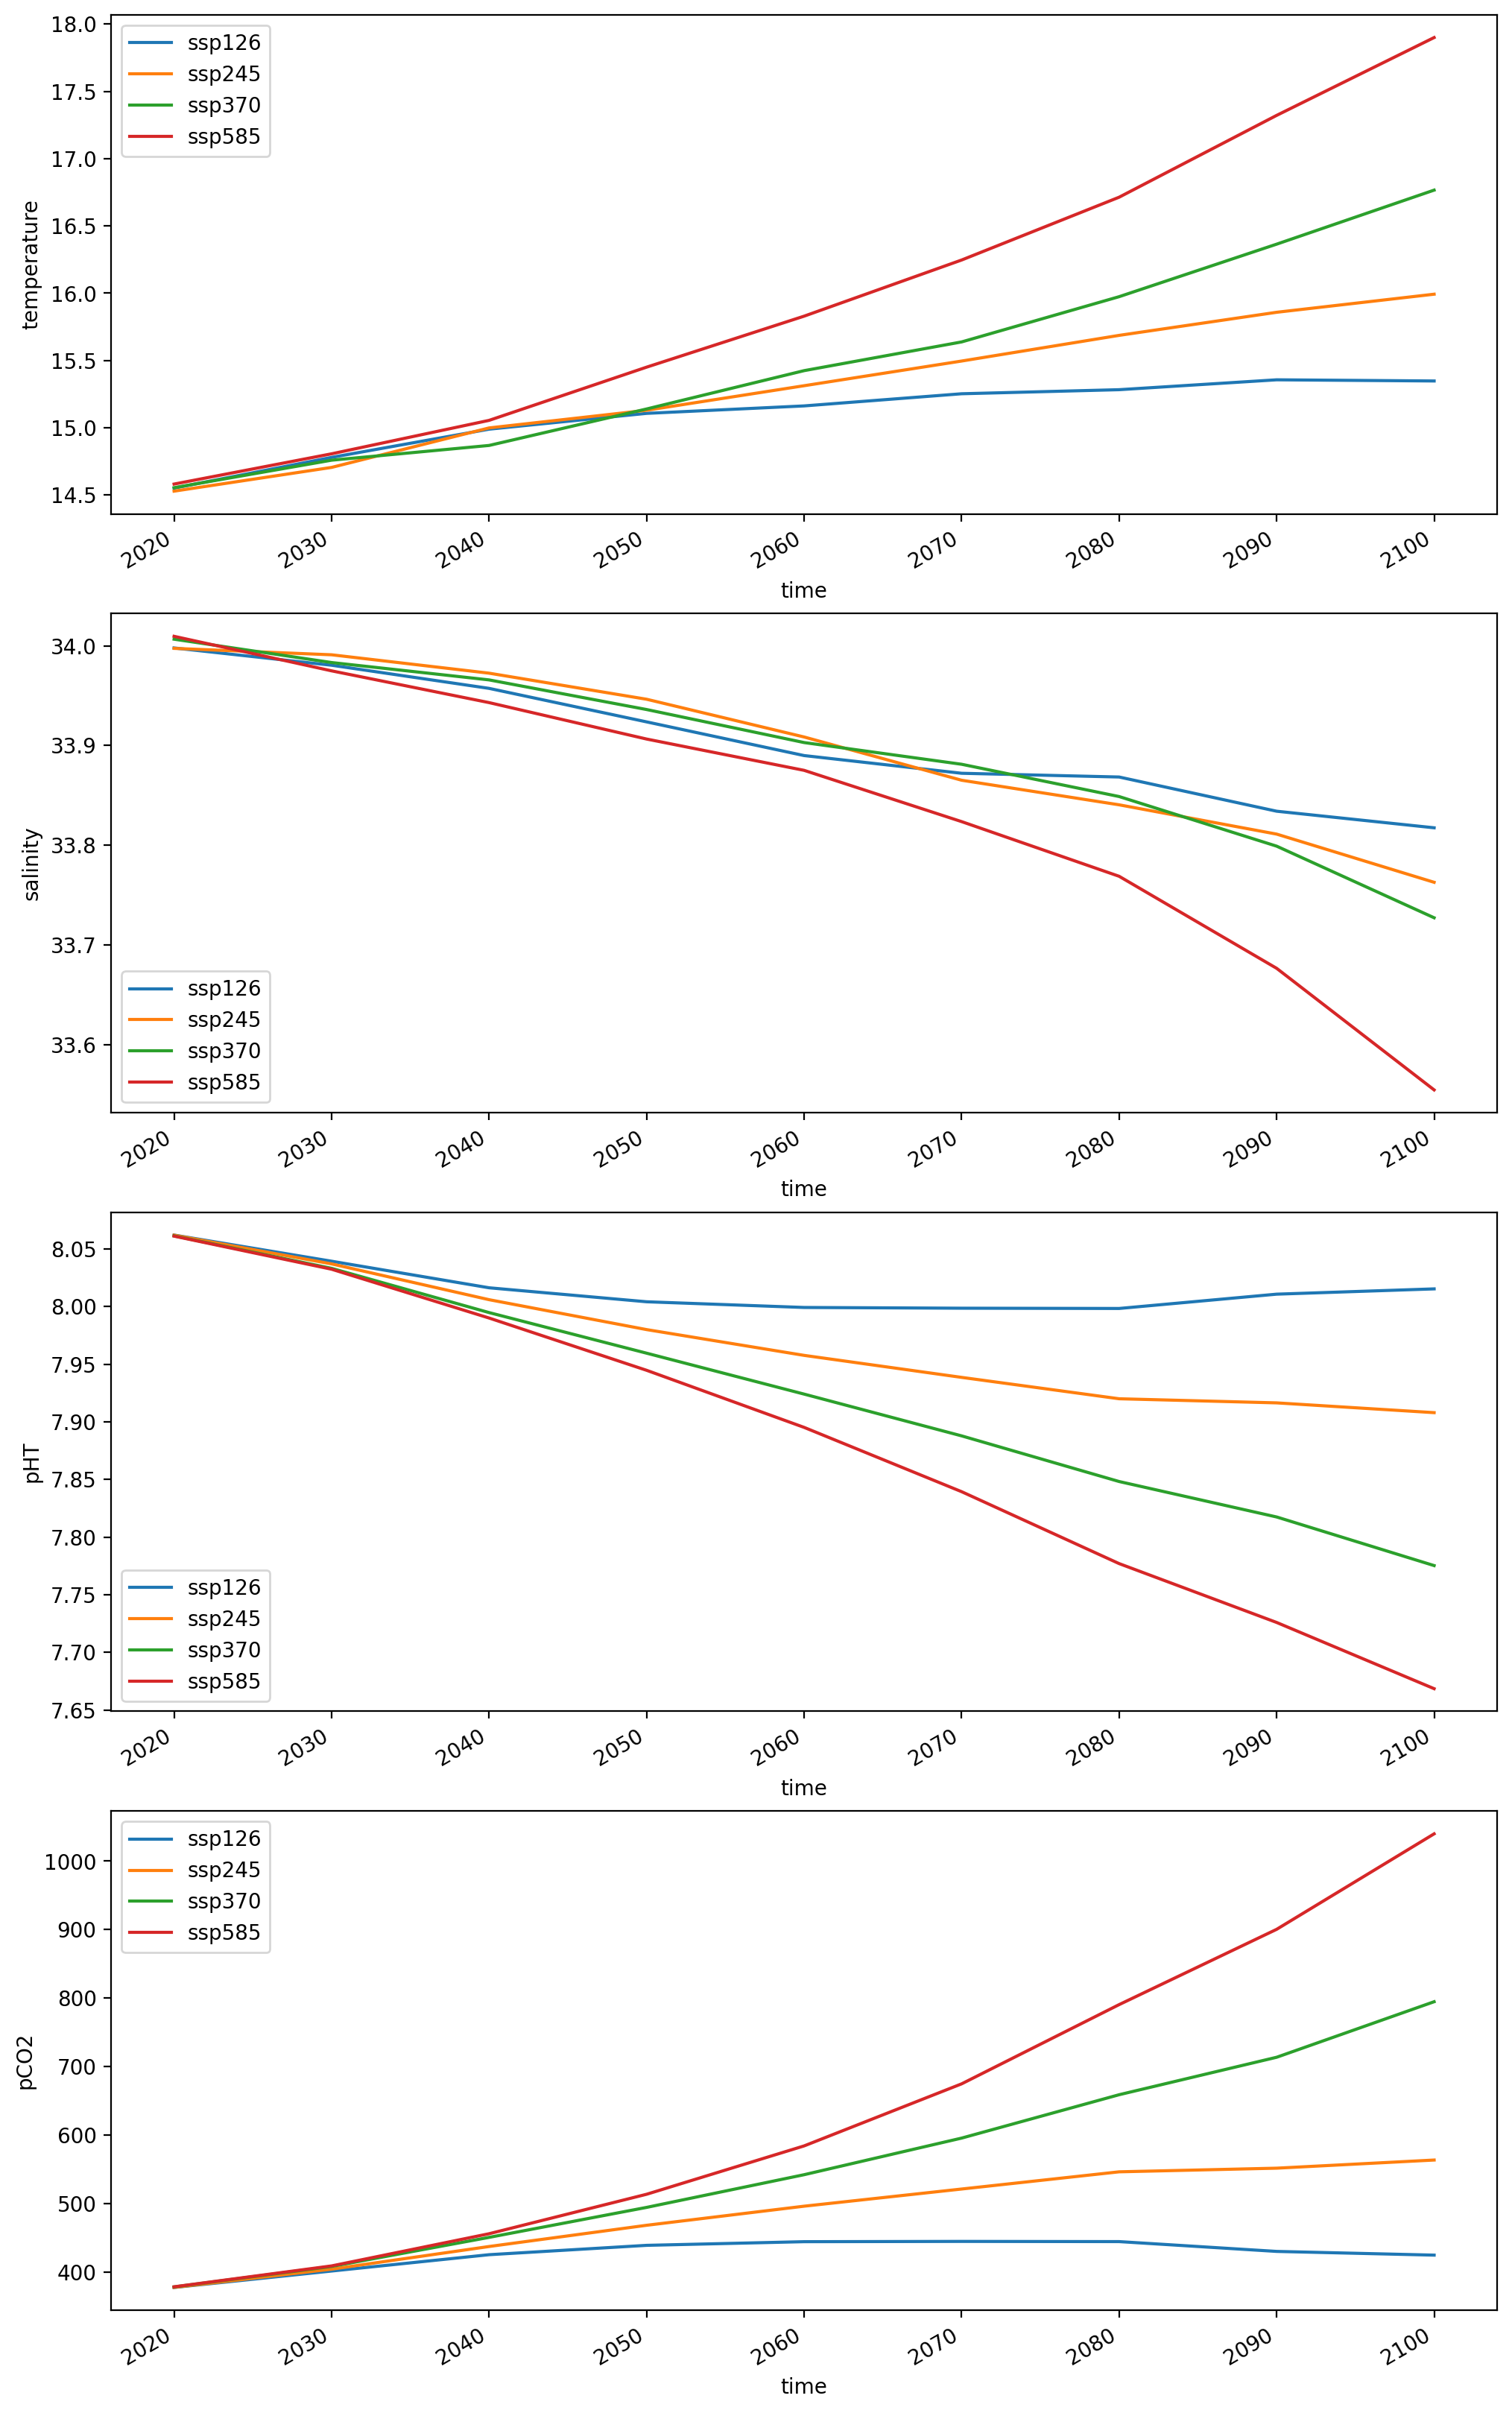

In [58]:
fig, axes = plt.subplots(figsize=(12,20),nrows=4)
ax0, ax1, ax2, ax3 = axes
for scenario in scenarios:
#    plt.legend()
    cesm[scenario].temperature.mean(dim=('latitude','longitude')).plot(ax=ax0,label=scenario)
    ax0.legend()
    cesm[scenario].salinity.mean(dim=('latitude','longitude')).plot(ax=ax1,label=scenario)
    ax1.legend(loc='lower left') #have to do distinctly because building different plot/legend, also move to lower left for more consistency
    cesm[scenario].pHT.mean(dim=('latitude','longitude')).plot(ax=ax2,label=scenario)
    ax2.legend(loc='lower left') 
    cesm[scenario].pCO2.mean(dim=('latitude','longitude')).plot(ax=ax3,label=scenario)
    ax3.legend()

### Arctic-Specific pH Maps

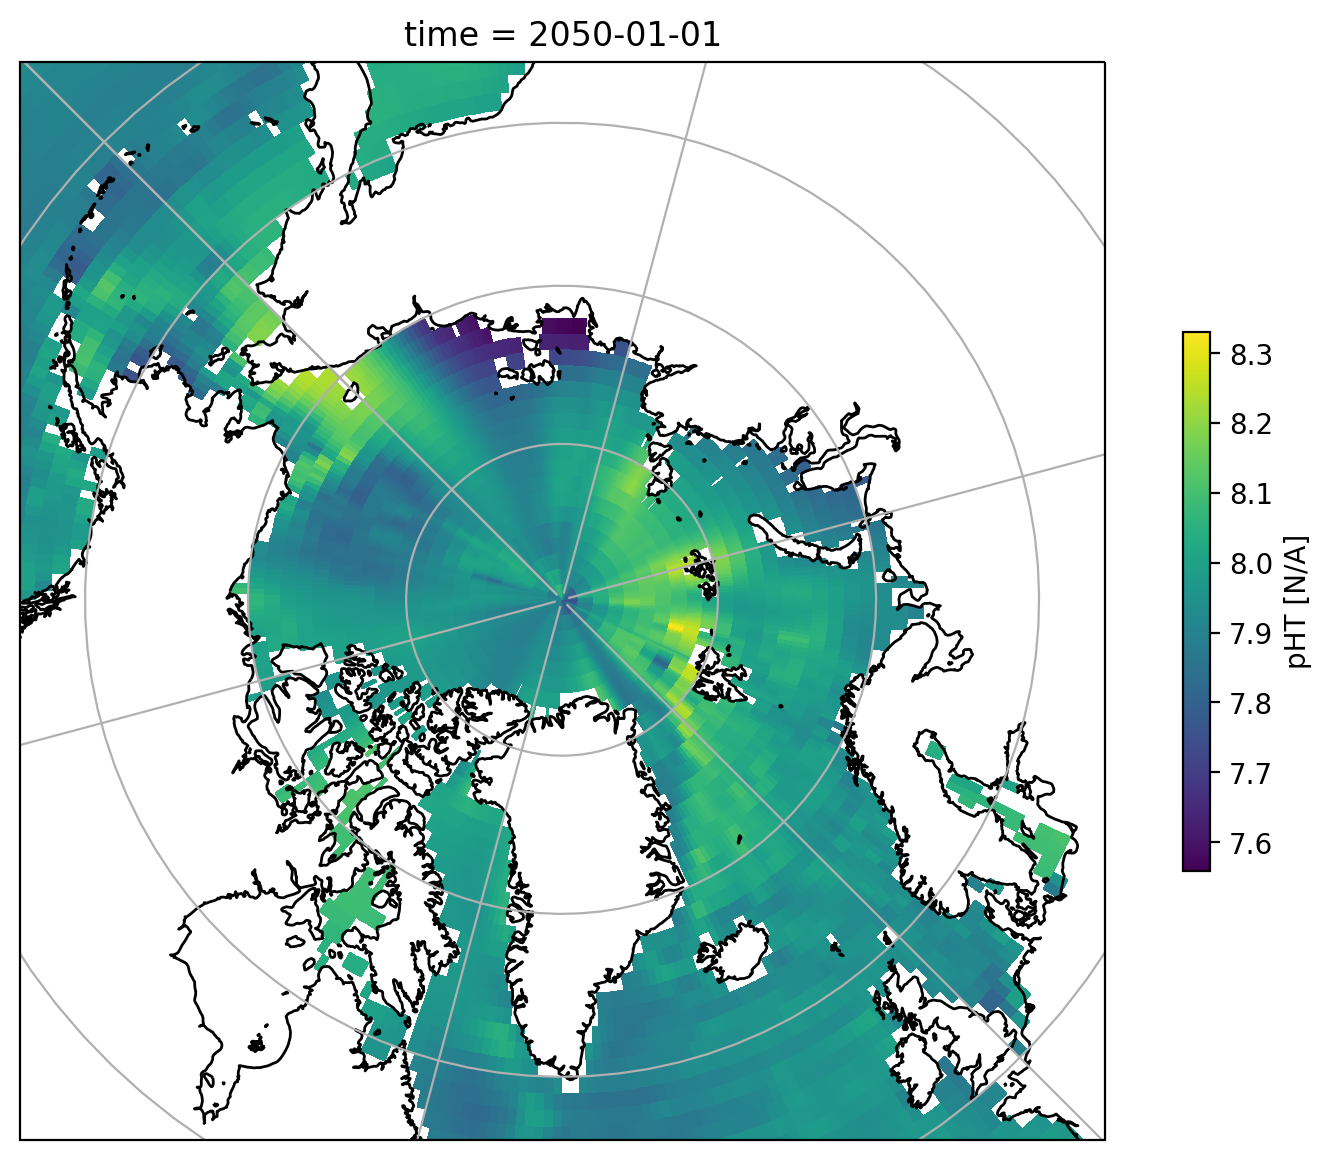

In [59]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.NorthPolarStereo(central_longitude=-45) #ccrs.NorthPolarStereo(central_longitude=-45) #other is -45, to match need 135
ax = plt.axes(projection=proj_ant)
ax.set_extent([0, 360, 100, 56], crs=ccrs.PlateCarree()) #100, 56
ax.coastlines()
ax.gridlines()

cesm['ssp585'].sel(time='2050').pHT.plot(cbar_kwargs={'shrink': 0.5},transform=ccrs.PlateCarree())

### Create Plots to Examine Sea Ice Data

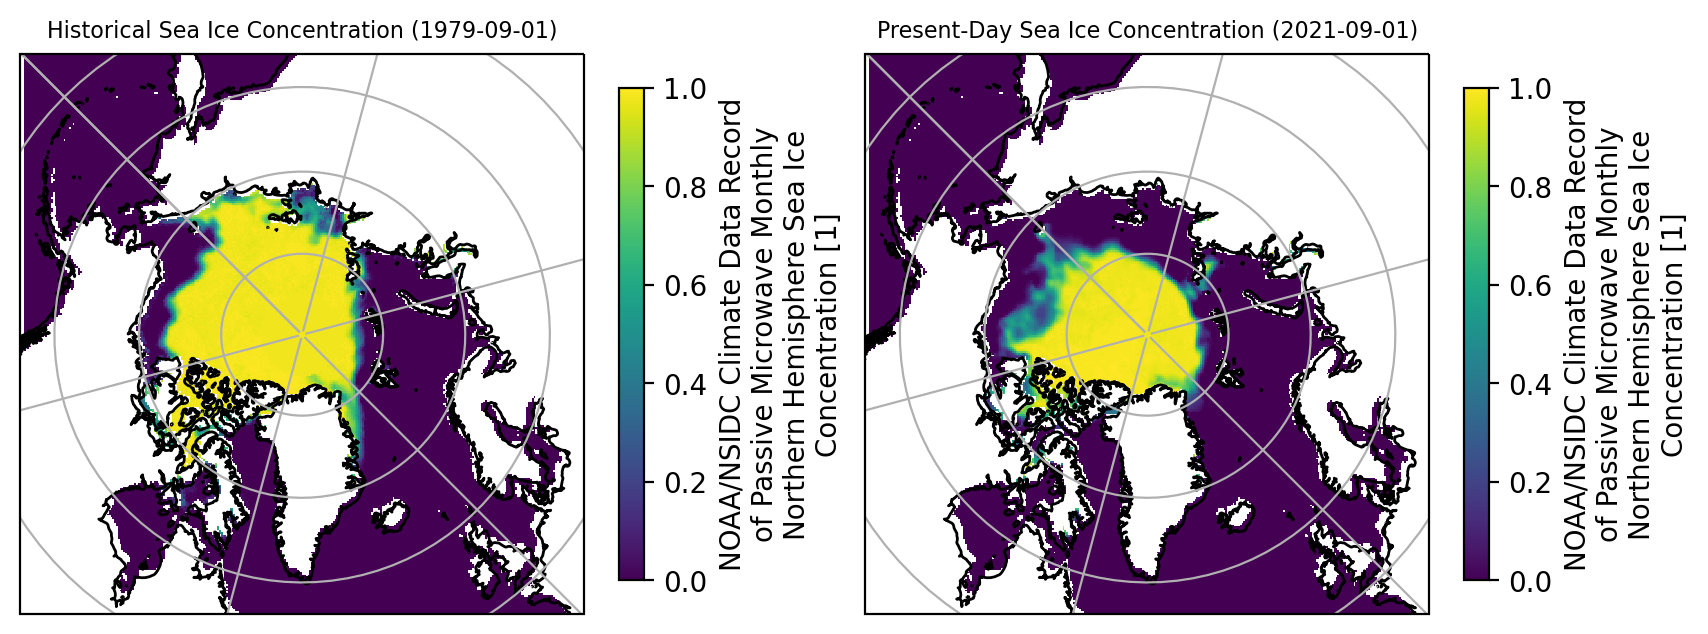

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(10,8),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-45)})
#fig = plt.figure(figsize=(10,7))
#proj_ant = ccrs.NorthPolarStereo(central_longitude=-45)
#ax = plt.axes(projection=proj_ant)
ax0, ax1 = axes 
for ax in ax0, ax1:
    ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    
ice_conc_hist = ds_ice.cdr_seaice_conc_monthly.sel(time='1979-09-01')
ice_conc_hist = ice_conc_hist.where(ice_conc_hist<=1)
ice_conc_hist.plot(ax=ax0,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4})
ax0.set_title('Historical Sea Ice Concentration (1979-09-01)')
ax0.title.set_size(8)

ice_conc_pres = ds_ice.cdr_seaice_conc_monthly.sel(time='2021-09-01') # did 10 to look at September, also try ds_ice.cdr_seaice_conc[ds_ice.cdr_seaice_conc.time=='2021-09-01']
ice_conc_pres = ice_conc_pres.where(ice_conc_pres<=1)
ice_conc_pres.plot(ax=ax1,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4}) 
ax1.set_title('Present-Day Sea Ice Concentration (2021-09-01)')
ax1.title.set_size(8)

Text(0.5, 1.0, 'Difference between Historical and Present Sea Ice Concentration')

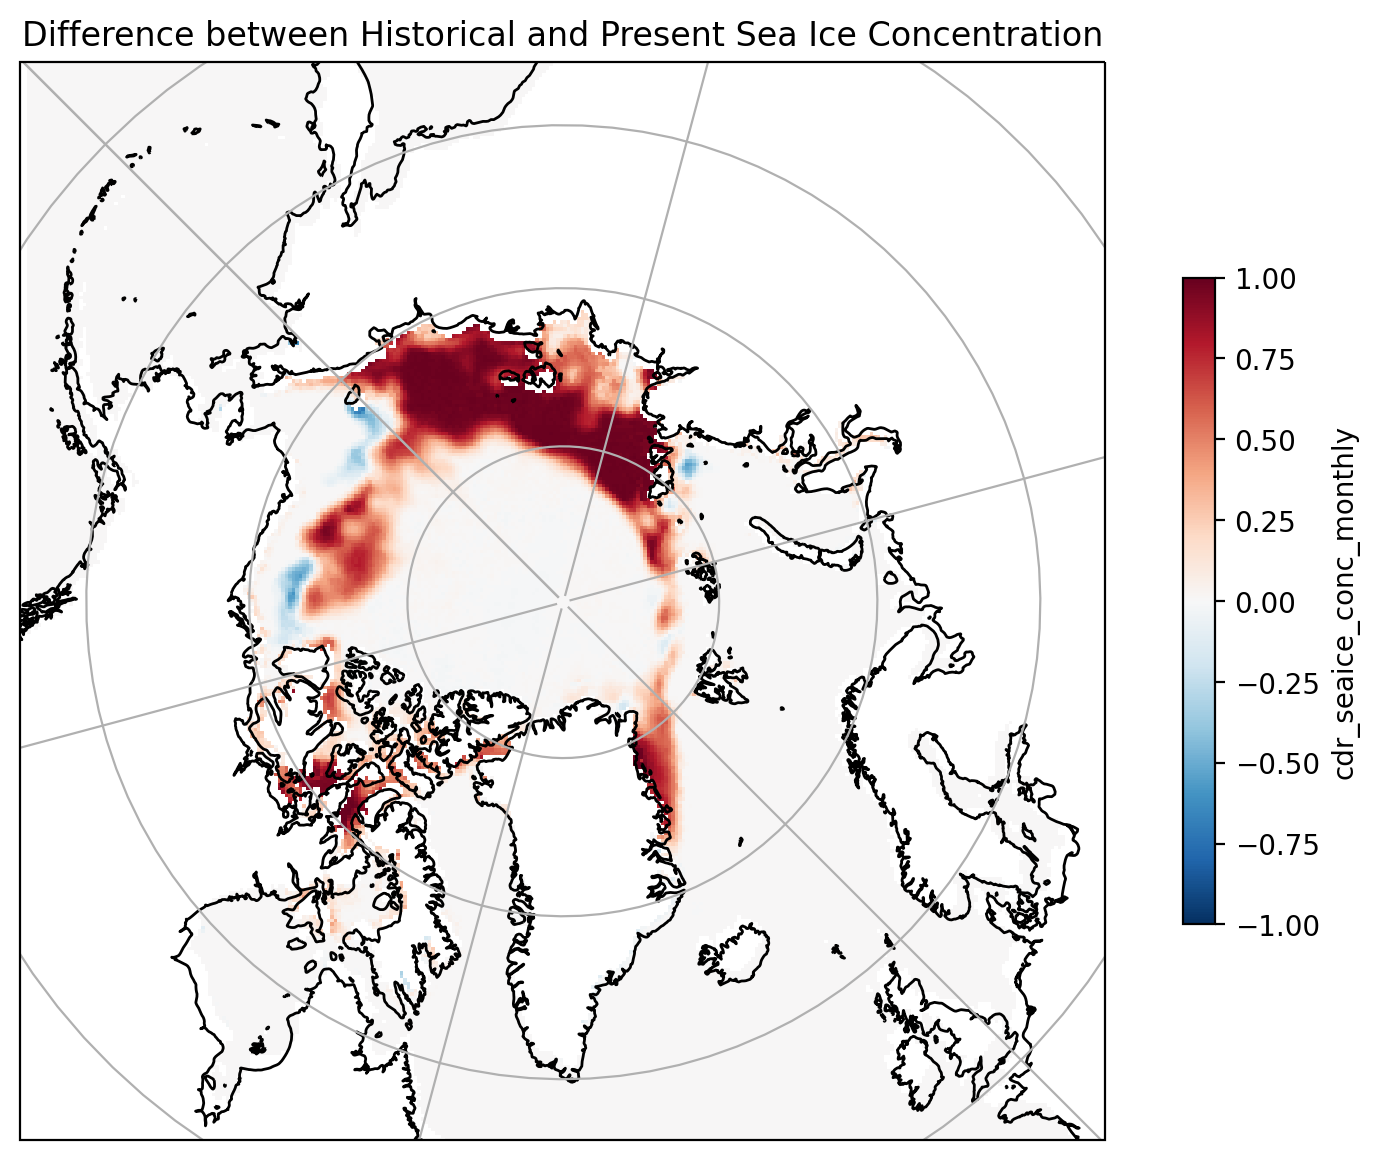

In [29]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.NorthPolarStereo(central_longitude=-45)
ax = plt.axes(projection=proj_ant)
ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ice_conc_diff = ice_conc_hist - ice_conc_pres
ice_conc_diff.plot(cbar_kwargs={'shrink': 0.6}) 
ax.set_title('Difference between Historical and Present Sea Ice Concentration')

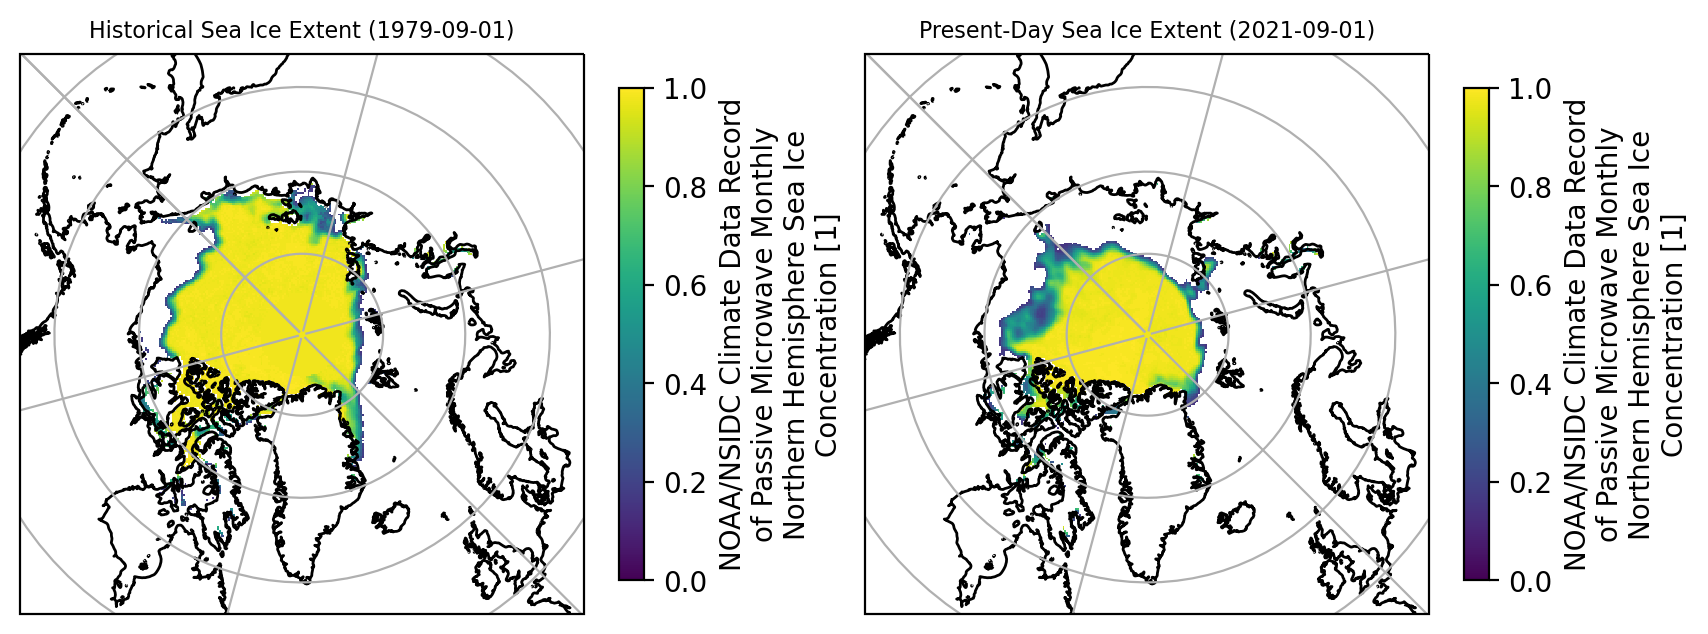

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(10,8),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-45)})
#fig = plt.figure(figsize=(10,7))
#proj_ant = ccrs.NorthPolarStereo(central_longitude=-45)
#ax = plt.axes(projection=proj_ant)
ax0, ax1 = axes 
for ax in ax0, ax1:
    ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()

ice_extent_hist = ice_conc_hist.where(ice_conc_hist>=0.15)
ice_extent_hist.plot(ax=ax0,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4})
ax0.set_title('Historical Sea Ice Extent (1979-09-01)')
ax0.title.set_size(8)

ice_extent_pres = ice_conc_pres.where(ice_conc_pres>=0.15)
ice_extent_pres.plot(ax=ax1,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4}) 
ax1.set_title('Present-Day Sea Ice Extent (2021-09-01)')
ax1.title.set_size(8)

In [31]:
# ice_extent_hist['longitude']= ice_extent_hist['longitude']+9.999 
# ice_extent_pres['longitude']= ice_extent_pres['longitude']+9.999 
# ice_extent_pres
# ice_extent_pres_mask = ice_conc_pres[ice_conc_pres>=0.15]
# type(ice_conc_pres)
# ice_extent_pres['longitude']

In [32]:
# ice_conc_pres>=0.15

In [33]:
# ice_conc_pres.where(ice_conc_pres>=0.15)

# Analysis and Resulting Figures

In [34]:
# test126 = cesm['ssp126'].sel(time='2020').interp_like(ice_conc_pres, method='nearest')
# test126.where(ice_conc_pres>=0.15).plot()

## Calculate sea ice concentration anomaly

In [35]:
ice_monthly = ds_ice.cdr_seaice_conc_monthly.mean(dim=('ygrid', 'xgrid'))
by_month = ice_monthly.groupby(ice_monthly['time'].dt.month)

In [36]:
by_month.mean()

<xarray.DataArray 'cdr_seaice_conc_monthly' (month: 12)>
array([0.4958386 , 0.49751723, 0.4999588 , 0.48087987, 0.44659713,
       0.40427953, 0.36631212, 0.3080037 , 0.2982376 , 0.33913657,
       0.39418   , 0.4589454 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

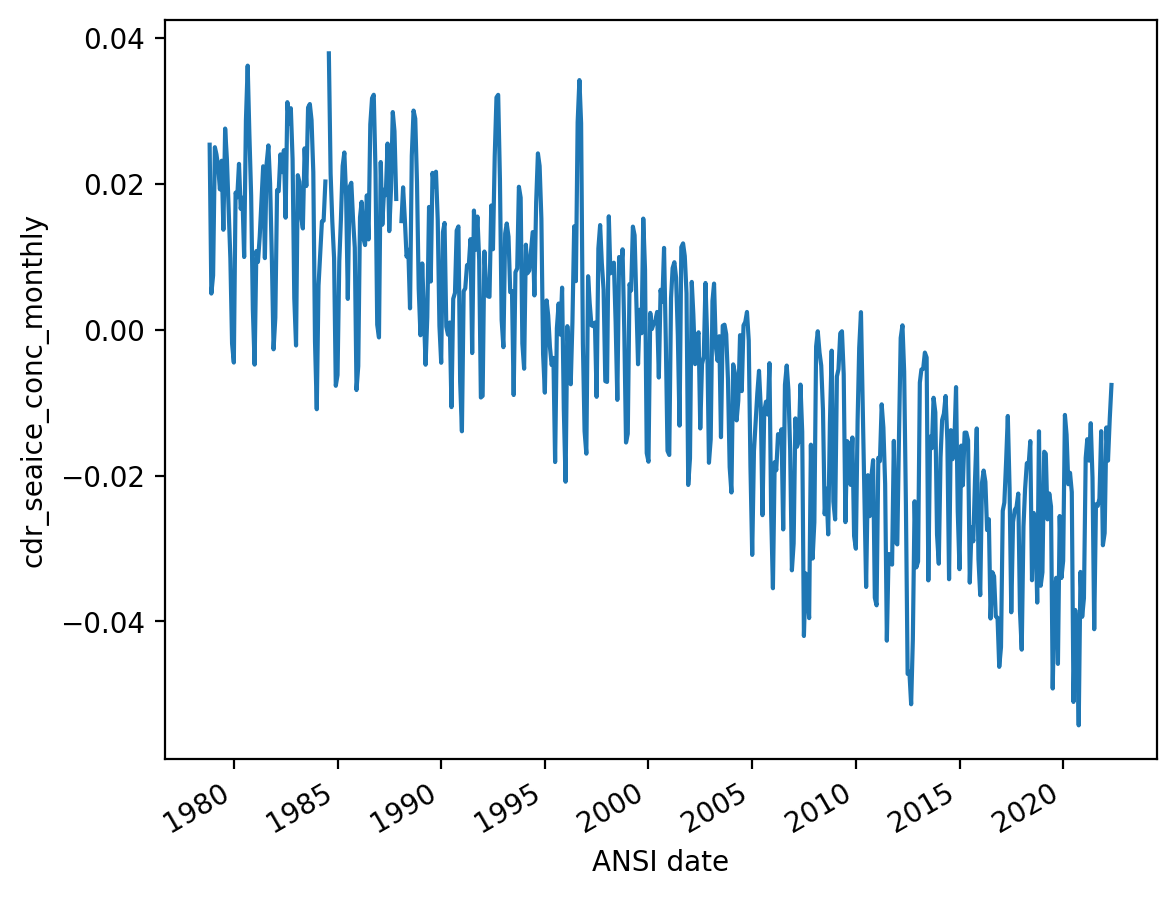

In [37]:
by_month = ice_monthly.groupby(ice_monthly['time'].dt.month) #note grouping conc values, not just datapoint counts
anomaly = by_month - by_month.mean()
anomaly.where(anomaly<0.5).plot()
ax.set_title('Monthly Anomaly of Sea Ice Concentration'); 

## Calculate all variable mid-century changes for each scenario

### Note: 
- Analysis does not use anomaly because CESM only provides decadal data, and unlikely that anomaly calculated at that frequency would meaningfully capture Arctic changes

In [38]:
def create_midcentury_differences(Select_date):
    start_2020 = cesm[scenario].sel(time='2020')
    selected_century = cesm[scenario].sel(time=Select_date,method='nearest')

    temp_difference = selected_century.temperature.mean(dim=('latitude','longitude'))-start_2020.temperature.mean(dim=('latitude','longitude'))
    salinity_difference = selected_century.salinity.mean(dim=('latitude','longitude'))-start_2020.salinity.mean(dim=('latitude','longitude'))
    pH_difference = selected_century.pHT.mean(dim=('latitude','longitude'))-start_2020.pHT.mean(dim=('latitude','longitude'))
    pCO2_difference = selected_century.pCO2.mean(dim=('latitude','longitude'))-start_2020.pCO2.mean(dim=('latitude','longitude'))
    
    changes_in_parameters = [('temp_difference',temp_difference),
                             ('salinity_difference',salinity_difference),
                             ('pH_difference',pH_difference),
                             ('pCO2_difference',pCO2_difference)]
    print(changes_in_parameters)

In [39]:
widgets.interact(create_midcentury_differences,Select_date=merged_dates)

interactive(children=(Dropdown(description='Select_date', options=(('2020', <xarray.DataArray 'time' ()>
array…

<function __main__.create_midcentury_differences(Select_date)>

# Conclusions